# Image Segmentation


This mainly will be using skimage methods and matplot and napari for viewing the images. 



## Import Lines

In [14]:
import pandas as pd
import imageio as io
import numpy as np

import napari
from skimage import filters, morphology, measure, exposure, segmentation, restoration
import skimage.io as skio
import scipy.stats as st
from scipy import ndimage as ndi
from scipy.signal import find_peaks
from scipy import sparse

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import plotly
import plotly.express as px
import plotly.graph_objects as go


## Reading in the Image

Image: cropped_Projections of Dec9_P117_mlsEGFP_uasRFP_D3T4MFLrotcr.Blind_fused1.tiff

In [ ]:
imstack1 = skio.imread('cropped_Projections_of_Dec9_P117_mlsEGFP_uasRFP_D3T4MFLrotcr.Blind_fused1.tif', plugin = 'tifffile')
z_size, x_size, y_size = imstack1.shape
z_scale = .5
xy_scale = 0.71
print('The mean of the TIFF stack is: ', imstack1.mean())
data = imstack1
print(f'number of dimensions: {imstack1.ndim}')
print(f'shape: {imstack1.shape}')
print(f'dtype: {imstack1.dtype}')

Looking at the histogram of the image stack.

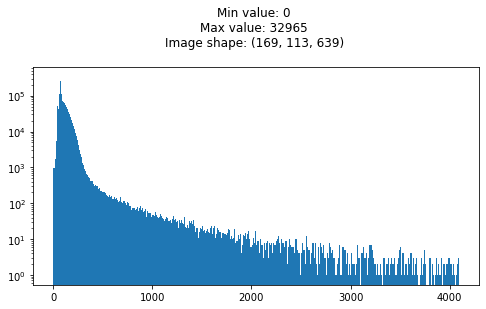

In [5]:

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(imstack1.flatten(), log=True,
        bins=4096, range=(0, 4096))

_ = ax.set_title('Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (imstack1.min(),
                    imstack1.max(),
                    imstack1.shape))

## Napari Viewer

What is used to view the cell in 3D. The spacing setting is rather arbitrary as it does not impact the actual image, just how it is portrayed within the viewer. For the sake of clear viewing, the "spacing" parameter will be set to .184 which is the nanometers for each step in the x and y positions.

In [6]:
spacing = np.array([.184,.184,.184])

## Exposure Adjustments

Comparing the following:

- Adaptive Histogram Equalization
- Rescale Intensity




### Histogram Equalization

The Adaptive Histogram Equalization is a Contrast Limited Adaptive Histogram Equalization(CLAHE). This algorithm is for local contrast enhancements. It uses the histograms computed over different tile regions of the image. The local details can therefore be enhanced even in regions that are darker or lighter than most of the image. 

Some of the parameters included in this function includes the image, kernel_size, clip_limit and nbins.
The kernel size defines the shape of the contextual regions used in the algorithm. By default, the kernel_size is 1/8 of image height by 1/8th of its width.

In [ ]:
data_adap = skimage.exposure.equalize_adapthist(data)
viewer_1 = napari.view_image(
    data_adap,
    contrast_limits = [0,1],
    scale = spacing,
    ndisplay = 3,
)

### Rescale Intensity

To decide which will provide better results, we will continue with histogram equalization and rescale intensity as two of the possible ones to improve the image.

Rescale intensity returns an image after streching or shrinking its intensity levels. There are two parameters, in_range and out_range, which are used to stretch or shrink the intensity range of the input image. 
By default, the min/max intensities of the input image are stretched to the limits allowed by the image's dtype since in_range defauls to "image" and out_range defaults to "dtype".
Our dtype is uint16.

We will be using rescale intensity.

In [ ]:
rescaled_intensity = skimage.exposure.rescale_intensity(data)

viewer_1.add_image(
    rescaled_intensity,
    scale = spacing,
)

Comparing the histograms between the original image, the rescaled intensity image, and the adaptive histogram image.

Text(0.5, 1.0, 'Adaptive Histogram Equalization \nMin value: 0 \nMax value: 1 \nImage shape: (169, 113, 639) \n')

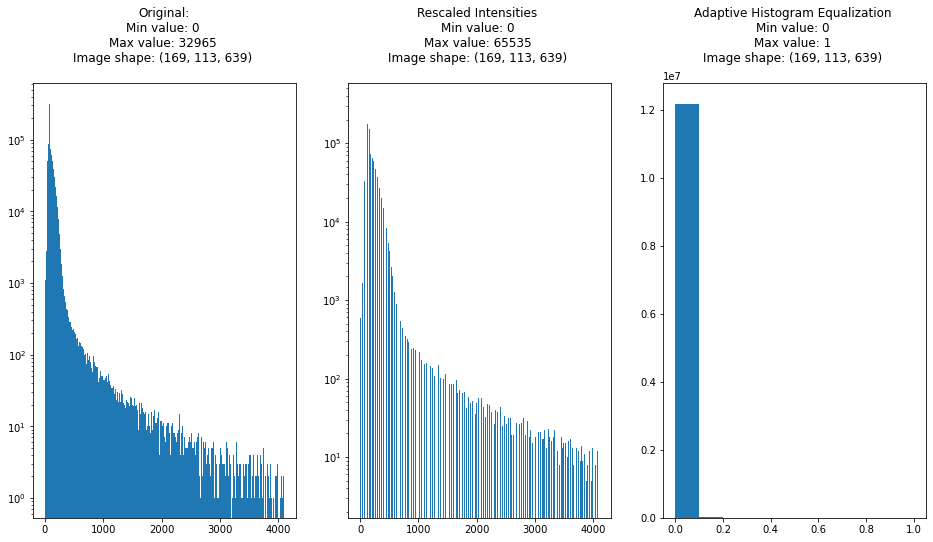

In [9]:

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16, 8))

ax1.hist(data.flatten(), log=True,
        bins=4096, range=(0, 4096))

ax1.set_title('Original:\n' 'Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (data.min(),
                    data.max(),
                    data.shape))
ax2.hist(rescaled_intensity.flatten(), log=True,
        bins=4096, range=(0, 4096))

ax2.set_title('Rescaled Intensities \n' 'Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (rescaled_intensity.min(),
                    rescaled_intensity.max(),
                    rescaled_intensity.shape))

ax3.hist(data_adap.flatten())

ax3.set_title('Adaptive Histogram Equalization \n' 'Min value: %i \n'
                 'Max value: %i \n'
                 'Image shape: %s \n'
                 % (data_adap.min(),
                    data_adap.max(),
                    data_adap.shape))

### Filters

These filters will include different blurs such as Gaussian and Median (for now, will remove depening on if one is distinctly better than the other).

## Processing Steps, Morphological, and Segmentation

- Edge Detection with Sobel Filters
- Gaussian Blur
- Multiotsu Threshold

**Morphological steps**
- Binary Closing
- Binary Opening
- Binary Dilation
- Binary Erosion

- Clear Border
- Distance Transform
- Smoothing of the distance transform with a gaussian blur
- Finding the local maxima with the smoothed distance transform
- Plotted points on the image


### Sobel filter

Finding edges in an image using the Sobel filter.
The edge filter is computed via the formula

sobel_mag = np.sqrt(sum(\[sobel(image, axis=i)**2
                         
                         for i in range(image.ndim)]) / image.ndim)

The magnitude is also computed if axis is a sequence.

In [ ]:
edges_sobel = filters.sobel(rescaled_intensity)
viewer_1.add_image(
    edges_sobel,
    scale = spacing,
    blending = 'additive',
    colormap = 'magenta',
)

#### Gaussian Blur

We'll apply the guassian blur to smooth out the image including any noise.
Gaussian noise arises in images due to sensor noise caused by poor illumination and/or high temperature, and electronic circuit noise.
Gaussian noise is statistical noise with the probability density function equal to the normal distribution of the data. Gaussian noise in images can be a result of the technology used to obtain the images through a variety of factors [1](https://miac.unibas.ch/SIP/06-Restoration.html#(7)). Though, when smoothing an image, which can be used to remove the noise, this can lead to an undesirable outcome such as a loss of edges due to those often correlating to blocked high-frequency values. 

In [ ]:
sigma_est_gaussian = restoration.estimate_sigma(edges_sobel, average_sigmas = True)
gaussian_sobel = filters.gaussian(edges_sobel,sigma=sigma_est_gaussian)
#gaussian_2 = filters.gaussian(clipped_data)

viewer_1.add_image(
    gaussian_sobel,
    scale = spacing,
)

### Otsu's Threshold







#### Otsu

Return threshold value based on Otsu’s method.

Either image or hist must be provided. If hist is provided, the actual histogram of the image is ignored.

In [ ]:
thresh_val_otsu= filters.threshold_otsu(gaussian_sobel)

otsu_mask_sobel = gaussian_sobel > thresh_val_otsu

viewer_1.add_image(
    otsu_mask_sobel,
    scale = spacing,
    #opacity = .3,
)

In [ ]:
multiotsu = filters.threshold_multiotsu(gaussian_sobel,2)

multiomask = gaussian_sobel > multiotsu

viewer_1.add_image(
    multiomask,
    scale=spacing,
)

#### Testing different morphology filters on the mask layer to see how to improve the mask and the watershed segmentation.


##### Otsu Mask
Tested in order:
- binary erosion (on the otsu mask)
- opening on the erosion 
- opening on the otsu mask 



In [ ]:
# testing the effects of erosion of the mask on watershed
erode = morphology.binary_erosion(otsu_mask_sobel)

viewer_1.add_image(
    erode,
    scale=spacing,
)

In [ ]:
#testing the effect of opening on erosion mask for water shed
opened = morphology.opening(erode)
viewer_1.add_image(
    opened,
    scale=spacing,
)

In [ ]:
# testing opening on just the otsu mask

opened_sobel = morphology.opening(otsu_mask_sobel)
viewer_1.add_image(
    opened_sobel,
    scale=spacing,
)

It appears that the opening on both erosion and just the otsu mask work really well.

##### Using the Multiotsu mask instead with these morphological functions.

These produce different (and even better results) than the standard otsu mask. 

We look at the different morphological functions that we have and see how they impact that mask and the watershed.

In [ ]:
# testing the effects of erosion of the mask on watershed
erode_multi = morphology.binary_erosion(multiomask)

viewer_1.add_image(
    erode_multi,
    scale=spacing,
)

In [ ]:
#testing the effect of opening on erosion mask for water shed
Multi_opened_erosion = morphology.opening(erode_multi)
viewer_1.add_image(
    Multi_opened_erosion,
    scale=spacing,
)

In [ ]:
# testing opening on just the otsu mask

opened_multi = morphology.opening(multiomask)
viewer_1.add_image(
    opened_multi,
    scale=spacing,
)

## Improve the segmentation


- use a smoothed version of the image directly

- smooth the distance map 

- use peak_local_max with min_distance parameter instead of morphology.local_maxima



#### More Morphological Steps to Improve the Mask

CODE: Closing, Opening, Dilation, Erosion steps
These provide cleaner results for the mask and picks up key parts of the mask that were otherwise missed. 
Information on these steps can be found [here](https://github.com/scikit-image/scikit-image/blob/main/skimage/morphology/binary.py#L121-L153).

**Binary Closing**: Returns a fast binary morphological closing of an image. Binary closing consists of dilation followed by erosion of the image. Closing is intended to remove small dark spots and connect small bright cracks. This performs faster on binary images (provided from the initial multiotsu mask) than grayscale closing.

**Binary Opening**: Erosion followed by dilation. 

**Binary Dilation**: Dilation enlarges bright regions and shrinks dark regions. 

**Binary Erosion**: Shrinks bright regions and enlarges dark regions

In [ ]:

multiotsu_closing = morphology.binary_closing(multiomask)
multiotsu_opening = morphology.binary_opening(multiotsu_closing)
multiotsu_dilation = morphology.binary_dilation(multiotsu_opening)
multiotsu_CODE = morphology.binary_erosion(multiotsu_dilation)


viewer_1.add_image(
    multiotsu_CODE,
    scale=spacing,
)

In [ ]:

cleared = segmentation.clear_border(multiotsu_CODE)
label_image = measure.label(cleared)
boundaries = segmentation.find_boundaries(label_image)


viewer_1.add_labels(
    boundaries,
    scale=spacing,
)

In [ ]:
# adding the points to the image at the specific locations in the mask

transformed = ndi.distance_transform_edt(multiotsu_CODE,sampling=spacing)
smooth_distance = filters.gaussian(transformed)

maxima = morphology.local_maxima(smooth_distance)
labeled_maxima = measure.label(maxima)

viewer_1.add_points(
    np.transpose(np.nonzero(labeled_maxima)),
    name = 'test points',
    scale=spacing,
    size=4,
    n_dimensional=True,
)

### Watershed method 

We have the watershed method to assist in segmentation. Using the masks created above (the otsu mask in combination with some morphological techniques such as opening and erosion) we were able to improve the otsu mask appearance. However, as we will find, the watershed method does a pretty good job until we look at the actual point location. That is where we have to refine things to improve the segmentation. 

The multiotsu also does a good job as a mask and separating the mitochondria so the watershed method may not be necessary.



In [ ]:

watershed_CODE = segmentation.watershed(edges_sobel,mask=multiotsu_CODE)
watershed_labels_CODE = measure.label(watershed_CODE)
viewer_1.add_labels(
    watershed_labels_CODE,
    scale = spacing,
)
